In [1]:
from djchurchland import *
from djchurchland.schema import * # Imports all schemas from the database
from djchurchland.utils import *
from djchurchland.chipmunk.psychometric import PsychometricFit
from chiCa.chiCa import separate_axes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.ndimage import uniform_filter1d

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['font.size'] = 12

save_dir = '/Users/gabriel/Desktop/BSN_figures/'

%matplotlib widget
%load_ext autoreload
%autoreload 2

[2025-08-12 16:18:12,335][INFO]: Connecting gabriel@localhost:3306
[2025-08-12 16:18:12,349][INFO]: Connected gabriel@localhost:3306


### Single animal plotting

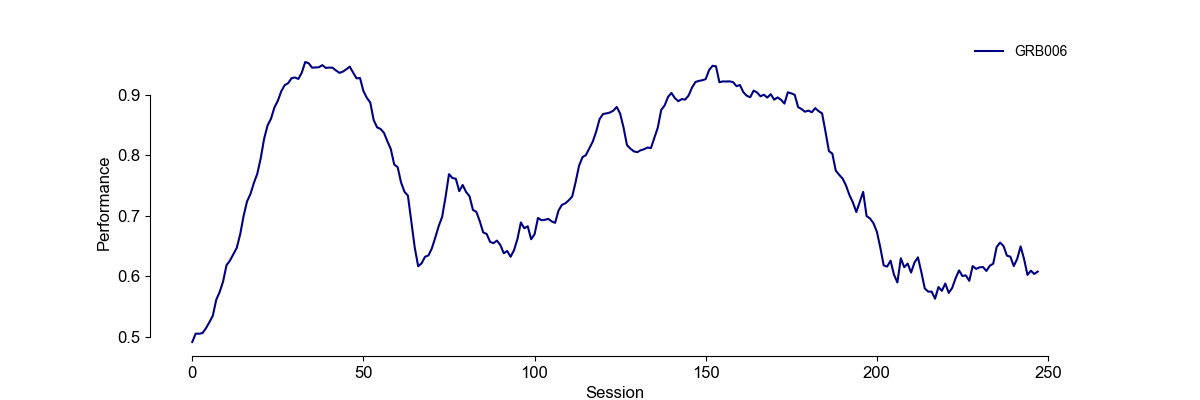

In [2]:
window_size = 10
fig, ax = plt.subplots(figsize=(12, 4))
mice = ["GRB006"]
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0,1,len(mice)))
for mouse, color in zip(mice, colors):
    
    trials_df = pd.DataFrame(Task.TrialSet() & f'subject_name = "{mouse}"')

    # Calculate average of first and last performance values and create new dataframe
    easy_perf_df = pd.DataFrame({
        'session_datetime': trials_df.session_datetime,
        'avg_performance': trials_df.performance.apply(lambda x: np.mean([x[0], x[-1]]))
    }).dropna().reset_index()

    y = uniform_filter1d(easy_perf_df.avg_performance, size=window_size)

    ax.plot(y, color = color, alpha = 1, label = f"{mouse}")

ax.set_xlabel('Session')
ax.set_ylabel('Performance')
ax.legend(fontsize=10, frameon=False, bbox_to_anchor=(1, 1.05));
separate_axes(ax)

### Multi animal learning plot

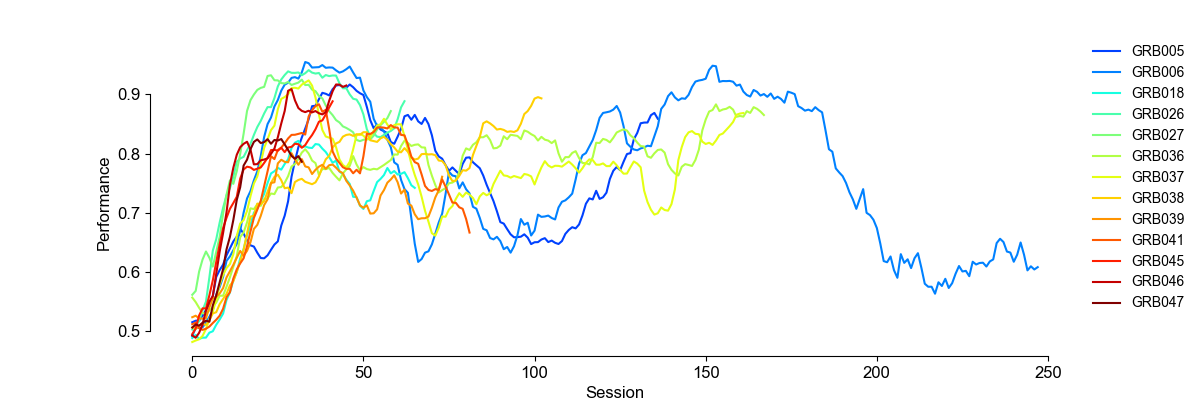

In [3]:
window_size = 10
fig, ax = plt.subplots(figsize=(12, 4))
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

mice = np.unique(PsychometricFit().fetch("subject_name"))
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0,1,len(mice)))
for mouse, color in zip(mice, colors):
    if mouse in ["GRB001", "GRB002", "GRB003", "GRB004", "GRB007"]: #mice only trained on 1s wait time version of the task
        continue
    
    trials_df = pd.DataFrame(Task.TrialSet() & f'subject_name = "{mouse}"')

    # Calculate average of first and last performance values and create new dataframe
    easy_perf_df = pd.DataFrame({
        'session_datetime': trials_df.session_datetime,
        'avg_performance': trials_df.performance.apply(lambda x: np.mean([x[0], x[-1]]))
    }).dropna().reset_index()

    y = uniform_filter1d(easy_perf_df.avg_performance, size=window_size)

    ax.plot(y, color = color, alpha = 1, label = f"{mouse}")

ax.set_xlabel('Session')
ax.set_ylabel('Performance')
ax.legend(fontsize=10, frameon=False, bbox_to_anchor=(1, 1.05));
separate_axes(ax)
# plt.savefig(pjoin(save_dir, 'performance_across_learning.svg'), format='svg', dpi=300, bbox_inches='tight')

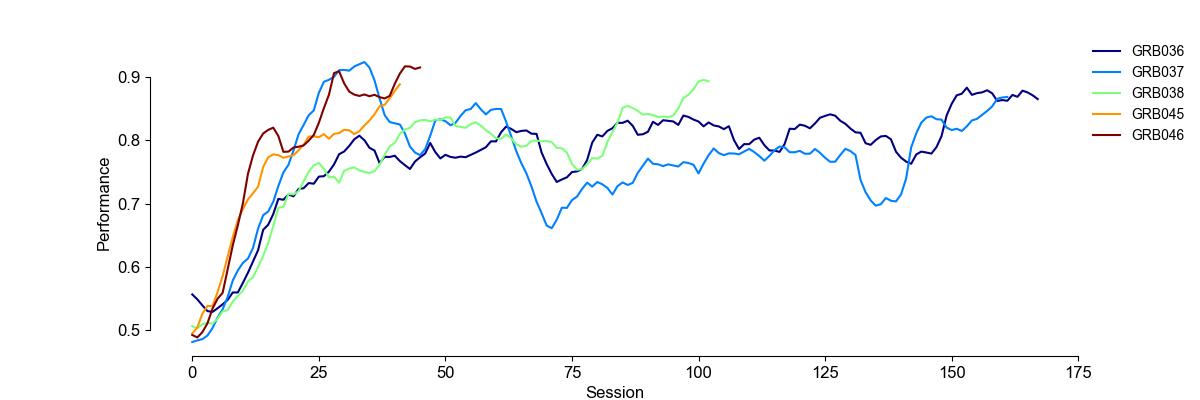

In [4]:
window_size = 10
fig, ax = plt.subplots(figsize=(12, 4))
mice = ["GRB036", "GRB037", "GRB038", "GRB045", "GRB046"]
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0,1,len(mice)))
for mouse, color in zip(mice, colors):
    
    trials_df = pd.DataFrame(Task.TrialSet() & f'subject_name = "{mouse}"')

    # Calculate average of first and last performance values and create new dataframe
    easy_perf_df = pd.DataFrame({
        'session_datetime': trials_df.session_datetime,
        'avg_performance': trials_df.performance.apply(lambda x: np.mean([x[0], x[-1]]))
    }).dropna().reset_index()

    y = uniform_filter1d(easy_perf_df.avg_performance, size=window_size)

    ax.plot(y, color = color, alpha = 1, label = f"{mouse}")

ax.set_xlabel('Session')
ax.set_ylabel('Performance')
ax.legend(fontsize=10, frameon=False, bbox_to_anchor=(1, 1.05));
separate_axes(ax)